---
title: "Candidates"
---

This notebook contains the code to deal with the candidates.

In [ ]:
#| default_exp candidates

In [ ]:
#| export
import polars as pl
import pandas as pd
import pandas
import xarray as xr

from datetime import timedelta

#### `Kerdo`

In [ ]:
#| export
from kedro.pipeline import Pipeline, node
from kedro.pipeline.modular_pipeline import pipeline

In [ ]:
#| eval: false
#| output: false
from ids_finder.utils.basic import load_catalog
catalog = load_catalog()
catalog.list()

[10/16/23 01:27:39] WARNING  /Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/ ]8;id=30095;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=507411;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py#109\109]8;;\
                             lazy_loader/__init__.py:78: KedroDeprecationWarning: 'ParquetDataSet'                 
                             has been renamed to 'ParquetDataset', and the alias will be removed in                
                             Kedro-Datasets 2.0.0                                                                  
                               attr = getattr(submod, name)                                                        
                                                                                                                   

                    WARNING  /Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/ ]8;id=470937;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=253605;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py#109\109]8;;\
                             kedro/io/data_catalog.py:300: FutureWarning: Defining the 'layer'                     
                             attribute at the top level is deprecated and will be removed in Kedro                 
                             0.19.0. Please move 'layer' inside the 'metadata' -> 'kedro-viz'                      
                             attributes. See                                                                       
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation                
                             .html#visualise-layers for more information.                                          
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/ ]8;id=226855;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=933246;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py#109\109]8;;\
                             lazy_loader/__init__.py:78: KedroDeprecationWarning: 'CSVDataSet' has                 
                             been renamed to 'CSVDataset', and the alias will be removed in                        
                             Kedro-Datasets 2.0.0                                                                  
                               attr = getattr(submod, name)                                                        
                                                                                                                   

                    WARNING  /Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/ ]8;id=392082;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=828546;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/warnings.py#109\109]8;;\
                             lazy_loader/__init__.py:78: KedroDeprecationWarning: 'GenericDataSet'                 
                             has been renamed to 'GenericDataset', and the alias will be removed in                
                             Kedro-Datasets 2.0.0                                                                  
                               attr = getattr(submod, name)                                                        
                                                                                                                   


[
    'JNO_index',
    'jno.raw_jno_ss_se_1sec',
    'jno.inter_jno_ss_se_1s',
    'jno.raw_state',
    'model.raw_jno_ss_se_1min',
    'model.preprocessed_jno_ss_se_1min',
    'candidates_all_1s',
    'sta.raw_sta_state',
    'parameters',
    'params:tau',
    'params:jno_start_date',
    'params:jno_end_date',
    'params:jno_1s_params',
    'params:jno_1s_params.bcols',
    'params:jno_1s_params.data_resolution',
    'params:jno.extract_params',
    'params:jno.extract_params.bcols',
    'params:jno.extract_params.data_resolution',
    'params:sta.extract_params',
    'params:sta.extract_params.bcols',
    'params:sta.extract_params.data_resolution'
]

## Plotting

In [ ]:
from ids_finder.utils.basic import calc_vec_mag
from pyspedas.cotrans.minvar_matrix_make import minvar_matrix_make
from pyspedas import tvector_rotate
from pytplot import timebar, store_data, tplot, split_vec, join_vec, tplot_options, options, highlight, degap
import pytplot

In [ ]:
## Plotting
def time_stamp(ts):
    "Return POSIX timestamp as float."
    return pd.Timestamp(ts, tz="UTC").timestamp()

def plot_basic(
    data: xr.DataArray, 
    tstart: pd.Timestamp, 
    tstop: pd.Timestamp,
    tau: timedelta, 
    mva_tstart=None, mva_tstop=None, neighbor: int = 1
):
    if mva_tstart is None:
        mva_tstart = tstart
    if mva_tstop is None:
        mva_tstop = tstop

    mva_b = data.sel(time=slice(mva_tstart, mva_tstop))
    store_data("fgm", data={"x": mva_b.time, "y": mva_b})
    minvar_matrix_make("fgm")  # get the MVA matrix

    temp_tstart = tstart - neighbor * tau
    temp_tstop = tstop + neighbor * tau

    temp_b = data.sel(time=slice(temp_tstart, temp_tstop))
    store_data("fgm", data={"x": temp_b.time, "y": temp_b})
    temp_btotal = calc_vec_mag(temp_b)
    store_data("fgm_btotal", data={"x": temp_btotal.time, "y": temp_btotal})

    tvector_rotate("fgm_mva_mat", "fgm")
    split_vec("fgm_rot")
    pytplot.data_quants["fgm_btotal"]["time"] = pytplot.data_quants["fgm_rot"][
        "time"
    ]  # NOTE: whenever using `get_data`, we may lose precision in the time values. This is a workaround.
    join_vec(
        [
            "fgm_rot_x",
            "fgm_rot_y",
            "fgm_rot_z",
            "fgm_btotal",
        ],
        new_tvar="fgm_all",
    )

    options("fgm", "legend_names", [r"$B_x$", r"$B_y$", r"$B_z$"])
    options("fgm_all", "legend_names", [r"$B_l$", r"$B_m$", r"$B_n$", r"$B_{total}$"])
    options("fgm_all", "ysubtitle", "[nT LMN]")
    tstart_ts = time_stamp(tstart)
    tstop_ts = time_stamp(tstop)
    # .replace(tzinfo=ZoneInfo('UTC')).timestamp()
    highlight(["fgm", "fgm_all"], [tstart_ts, tstop_ts])
    
    degap("fgm")
    degap("fgm_all")

def format_candidate_title(candidate: pandas.Series):
    format_float = lambda x: rf"$\bf {x:.2f} $" if isinstance(x, (float, int)) else rf"$\bf {x} $"

    base_line = rf'$\bf {candidate.get("type", "N/A")} $ candidate (time: {candidate.get("time", "N/A")}) with index '
    index_line = rf'i1: {format_float(candidate.get("index_std", "N/A"))}, i2: {format_float(candidate.get("index_fluctuation", "N/A"))}, i3: {format_float(candidate.get("index_diff", "N/A"))}'
    info_line = rf'$B_n/B$: {format_float(candidate.get("BnOverB", "N/A"))}, $dB/B$: {format_float(candidate.get("dBOverB", "N/A"))}, $(dB/B)_{{max}}$: {format_float(candidate.get("dBOverB_max", "N/A"))},  $Q_{{mva}}$: {format_float(candidate.get("Q_mva", "N/A"))}'
    title = rf"""{base_line}
    {index_line}
    {info_line}"""
    return title

def plot_candidates(
    candidates: pandas.DataFrame, candidate_type=None, num=4, plot_func=plot_candidate
):
    """Plot a set of candidates.

    Parameters:
    - candidates (pd.DataFrame): DataFrame containing the candidates.
    - candidate_type (str, optional): Filter candidates based on a specific type.
    - num (int): Number of candidates to plot, selected randomly.
    - plot_func (callable): Function used to plot an individual candidate.

    """

    # Filter by candidate_type if provided
    
    candidates = get_candidates(candidates, candidate_type, num)

    # Plot each candidate using the provided plotting function
    for _, candidate in candidates.iterrows():
        plot_func(candidate)

In [ ]:

def plot_candidate_xr(candidate: pandas.Series, sat_fgm: xr.DataArray, tau: timedelta):
    if pd.notnull(candidate.get("d_tstart")) and pd.notnull(candidate.get("d_tstop")):
        plot_basic(
            sat_fgm,
            candidate["tstart"],
            candidate["tstop"],
            tau,
            candidate["d_tstart"],
            candidate["d_tstop"],
        )
    else:
        plot_basic(sat_fgm, candidate["tstart"], candidate["tstop"], tau)

    tplot_options("title", format_candidate_title(candidate))

    if "d_time" in candidate.keys():
        d_time_ts = time_stamp(candidate["d_time"])
        timebar(d_time_ts, color="red")
    if "d_tstart" in candidate.keys() and not pd.isnull(candidate["d_tstart"]):
        d_start_ts = time_stamp(candidate["d_tstart"])
        timebar(d_start_ts)
    if "d_tstop" in candidate.keys() and not pd.isnull(candidate["d_tstop"]):
        d_stop_ts = time_stamp(candidate["d_tstop"])
        timebar(d_stop_ts)

    # tplot(['fgm','fgm_all'])
    tplot("fgm_all")

## Candidate class

In [ ]:
#| export
from pprint import pprint

In [ ]:
#| export
class CandidateID:
    def __init__(self, time, df: pl.DataFrame) -> None:
        self.time = pd.Timestamp(time)
        self.data = df.row(
            by_predicate=(pl.col("time") == self.time), 
            named=True
        )

    def __repr__(self) -> str:
        # return self.data.__repr__()
        pprint(self.data)
        return ''
    
    def calc_duration(self, sat_fgm):
        return calc_candidate_duration(self.data, sat_fgm)
    
    def calc_d_duration(self, sat_fgm):
        return calc_candidate_d_duration(self.data, sat_fgm)
    
    def plot(self, sat_fgm, tau):
        plot_candidate_xr(self.data, sat_fgm, tau)
        pass
        

In [ ]:
sta_candidates_1s: pl.DataFrame = catalog.load('candidates.sta_1s')
jno_candidates_1s = catalog.load('candidates.jno_1s')

sta_mag : pl.LazyFrame = catalog.load('sta.inter_mag_rtn_1s')
jno_mag : pl.LazyFrame = catalog.load('sta.inter_mag_rtn_1s')

16-Oct-23 08:51:41 INFO     16-Oct-23 08:51:41: Loading data from 'candidates.sta_1s'           ]8;id=265122;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=989511;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                            (GenericDataset)...                                                                    

16-Oct-23 08:51:42 INFO     16-Oct-23 08:51:42: Loading data from 'candidates.jno_1s'           ]8;id=441403;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=520584;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                            (GenericDataset)...                                                                    

                   INFO     16-Oct-23 08:51:42: Loading data from 'sta.inter_mag_rtn_1s'        ]8;id=230410;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=269216;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                            (PolarsDataset)...                                                                     

                   INFO     16-Oct-23 08:51:42: Loading data from 'sta.inter_mag_rtn_1s'        ]8;id=989003;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=637065;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                            (PolarsDataset)...                                                                     

In [ ]:
from ids_finder.utils.basic import df2ts, pmap
from fastcore.utils import *

In [ ]:

def plot_candidate(candidate, mag_data: pl.LazyFrame, b_cols = ['BX', 'BY', 'BZ']):
    temp_tstart = candidate["tstart"]
    tmep_tstop = candidate["tstop"]
    tau = tmep_tstop - temp_tstart

    temp_mag_data = (
        mag_data.filter(pl.col("time").is_between(temp_tstart - tau, tmep_tstop + tau))
        .with_columns(pl.col("time").dt.cast_time_unit("ns"))
        .collect()
    )
    
    sat_fgm = df2ts(temp_mag_data, b_cols)
    plot_candidate_xr(candidate, sat_fgm, tau)

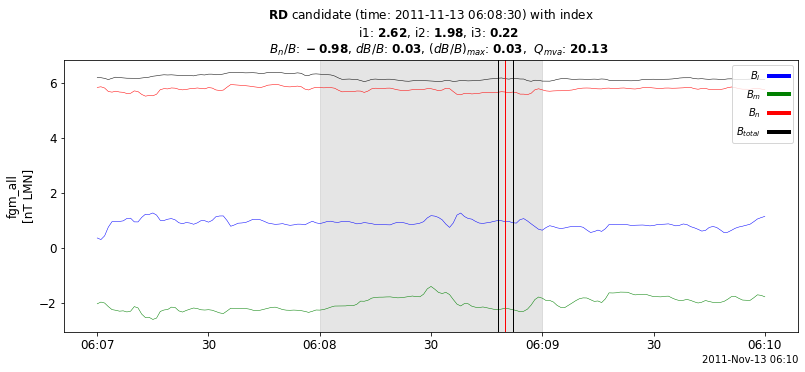

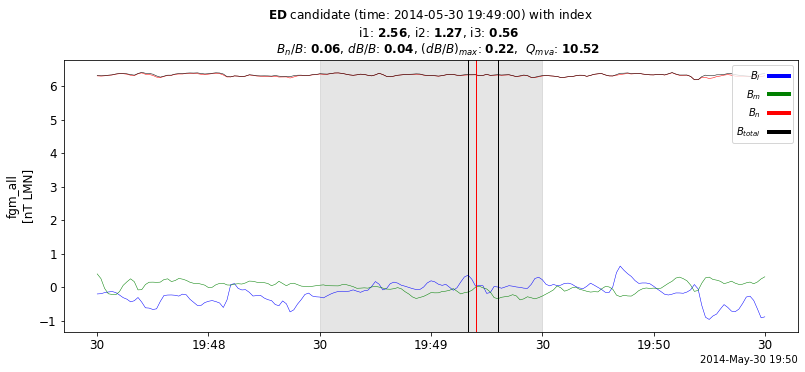

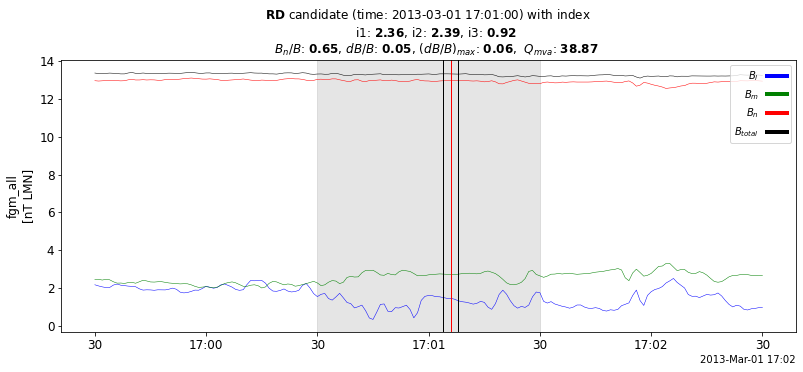

[None, None, None]

In [ ]:
n = 3
# list(sta_candidates_1s.sample(n).iter_rows(named=True) | pmap(plot_candidate, mag_data=sta_mag))

candidates = jno_candidates_1s.sample(n)
list(candidates.iter_rows(named=True) | pmap(plot_candidate, mag_data=jno_mag))


## Naming conventions

In [ ]:
#| export
sw_vec_rtn_cols = ["sw_vel_r", "sw_vel_t", "sw_vel_n"]  # solar wind velocity vector in RTN coordinate system
b_vecL_rtn_cols = ["b_vecL_r", "b_vecL_t", "b_vecL_n"]  # major eigenvector

#### Rename mapping

This sector can be removed after refactoring all the codes

In [ ]:
#| export
candidates_columns_name_mapping = {
   "Vl_x": "b_vecL_r",
    "Vl_y": "b_vecL_t",
    "Vl_z": "b_vecL_n",
}

In [ ]:
#| export
import polars as pl

from ids_finder.utils.basic import df2ts, pl_norm
import xarray as xr
from xarray_einstats import linalg

In [ ]:
#| export
def vector_project(v1,v2, dim="v_dim"):
    return xr.dot(v1 , v2, dims=dim) / linalg.norm(v2, dims=dim)

def vector_project_pl(df: pl.DataFrame, v1_cols, v2_cols, name=None):
    
    v1 = df2ts(df, v1_cols).assign_coords(v_dim=["r","t","n"])
    v2 = df2ts(df, v2_cols).assign_coords(v_dim=["r","t","n"]) 
    result = vector_project(v1, v2, dim="v_dim")
    
    return df.with_columns(
        pl.Series(result.data).alias(name or "v_proj")
    )

In [ ]:
#| export
import astropy.units as u
from astropy.constants import mu0
from plasmapy.formulary.lengths import inertial_length

In [ ]:
#| export
def compute_inertial_length(df: pl.DataFrame):
    
    result = inertial_length(df['sw_density'].to_numpy() * u.cm**(-3), 'H+').to(u.km)
    
    return df.with_columns(
        ion_inertial_length = pl.Series(result.value)
    )

j_factor = ((u.nT/u.s) * (1 / mu0 / (u.km/u.s) )).si.value


def unitize(df: pl.DataFrame):
    """unitize the columns in the dataframe with
    """

    return df.with_columns(
        j0 = pl.col('j0') * j_factor,
    )

In [ ]:
# | export
def combine_features(candidates: pl.DataFrame, sat_states: pl.DataFrame):
    updated_candidates = (
        candidates.rename(candidates_columns_name_mapping)
        .sort("time")
        .join_asof(sat_states.sort("time"), on="time")
    )

    df = (
        updated_candidates.with_columns(
            duration=pl.col("d_tstop") - pl.col("d_tstart"),
        )
        .pipe(vector_project_pl, sw_vec_rtn_cols, b_vecL_rtn_cols, name="sw_vel_l")
        .with_columns(
            sw_vel_mn=(pl.col("sw_speed") ** 2 - pl.col("sw_vel_l") ** 2).sqrt()
        )
        .with_columns(
            L_mn=pl.col("sw_vel_mn") * pl.col("duration").dt.nanoseconds() / 1e9,
            j0=pl.col("d_star") / pl.col("sw_vel_mn"),
        )
        .pipe(compute_inertial_length)
        .pipe(unitize)
        .with_columns(L_mn_norm=pl.col("L_mn") / pl.col("ion_inertial_length"))
    )

    return df

## Pipelines

In [ ]:
#| export
from kedro.pipeline import Pipeline, node
from kedro.pipeline.modular_pipeline import pipeline

In [ ]:
# | export
def create_candidate_pipeline(sat_id, **kwargs) -> Pipeline:
    time_resolution = "1s"

    node_combine_features = node(
        combine_features,
        inputs=[
            f"{sat_id}.feature_{time_resolution}",
            f"{sat_id}.primary_state_rtn_1h",
        ],
        outputs=f"candidates.{sat_id}_{time_resolution}",
    )

    nodes = [node_combine_features]
    return pipeline(nodes)